# 1C Sales prediction

In [1]:
!pip install lofo-importance

In [2]:
!pip install pandarallel

  Created wheel for pandarallel: filename=pandarallel-1.4.5-cp36-none-any.whl size=16025 sha256=fc29b2c9307c1330ec07116e95f7afec52341abf46b6444c495c3d6eddebd9bf
  Stored in directory: /root/.cache/pip/wheels/fa/70/d9/6a27d7fdddb6a7c10af68fffaf6f0a96846c750a840280f7bc
Successfully built pandarallel


In [3]:
import numpy as np
import pandas as pd
import dateutil
import datetime as dt
from datetime import date
from pandarallel import pandarallel
import matplotlib.pyplot as plt
import seaborn as sns
import re
import gc
from tqdm.notebook import tqdm
import pickle
import statsmodels.api as sm
from pylab import rcParams
from itertools import permutations, product

import lightgbm as lgb

from lightgbm import LGBMRegressor
from lofo import LOFOImportance, FLOFOImportance, Dataset, plot_importance

from sklearn.metrics import (mean_squared_log_error, mean_squared_error,
                             mean_absolute_error)
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from sklearn.model_selection import train_test_split, KFold
import warnings

/opt/conda/lib/python3.6/site-packages/lofo/lofo_importance.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Pandarallel is needed to parse dates from the initial dataset a little faster:

In [4]:
pandarallel.initialize()

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


Reduce RAM usage. From https://www.kaggle.com/caesarlupum/ashrae-start-here-a-gentle-introduction:

In [5]:
## Function to reduce the DF size
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

## Import and prepare data

In [6]:
train_df = pd.read_csv('../readonly/final_project_data/sales_train.csv')
test_df = pd.read_csv('../readonly/final_project_data/test.csv')
item_df = pd.read_csv('../readonly/final_project_data/items.csv')
item_cat_df = pd.read_csv('../readonly/final_project_data/item_categories.csv')
shop_df = pd.read_csv('../readonly/final_project_data//shops.csv')

USD/RUB exchange rate taken from https://www.finam.ru/profile/forex/usd-rub/export/ :

In [7]:
exch_rate = pd.read_csv('../input/1c-params/exchange_rate.csv', sep=',', parse_dates=['<DATE>'])
exch_rate = exch_rate.drop(['<TICKER>', '<PER>', '<TIME>'], axis=1)
exch_rate = exch_rate.rename(columns={'<DATE>':'date', '<CLOSE>':'rate'})

Parsing dates (pandarallel function parallel_apply):

In [8]:
train_df['date'] = train_df['date'].parallel_apply(dateutil.parser.parse, dayfirst=True)

### Items data

Borrowed from https://www.kaggle.com/kyakovlev/1st-place-solution-part-1-hands-on-data :

In [9]:
def name_correction(x):
    x = x.lower()
    x = x.partition('[')[0]
    x = x.partition('(')[0]
    x = re.sub('[^A-Za-z0-9А-Яа-я]+', ' ', x)
    x = x.replace('  ', ' ')
    x = x.strip()
    return x

In [10]:
item_df['item_name'] = item_df['item_name'].apply(name_correction)

In [11]:
item_df['item_name'].unique().shape

(18121,)

In [12]:
item_df.shape

(22170, 3)

There are some repeating items in the dataset

### Item categories data

In [13]:
item_cat_df['new_cats'] = (item_cat_df['item_category_name']
                           .str.split(' - ').apply(lambda x: x[0]))

In [14]:
item_cat_df['new_cats'].unique()

array(['PC', 'Аксессуары', 'Билеты (Цифра)', 'Доставка товара',
       'Игровые консоли', 'Игры', 'Игры Android', 'Игры MAC', 'Игры PC',
       'Карты оплаты (Кино, Музыка, Игры)', 'Карты оплаты', 'Кино',
       'Книги', 'Музыка', 'Подарки', 'Программы', 'Служебные',
       'Чистые носители (шпиль)', 'Чистые носители (штучные)',
       'Элементы питания'], dtype=object)

In [15]:
item_cat_df['new_subcats'] = (item_cat_df['item_category_name']
                           .str.split(' - ').apply(lambda x: x[-1]))

In [16]:
item_cat_df['new_subcats'].unique()

array(['Гарнитуры/Наушники', 'PS2', 'PS3', 'PS4', 'PSP', 'PSVita',
       'XBOX 360', 'XBOX ONE', 'Билеты (Цифра)', 'Доставка товара',
       'Прочие', 'Аксессуары для игр', 'Цифра', 'Дополнительные издания',
       'Коллекционные издания', 'Стандартные издания',
       'Карты оплаты (Кино, Музыка, Игры)', 'Live!', 'Live! (Цифра)',
       'PSN', 'Windows (Цифра)', 'Blu-Ray', 'Blu-Ray 3D', 'Blu-Ray 4K',
       'DVD', 'Коллекционное', 'Артбуки, энциклопедии', 'Аудиокниги',
       'Аудиокниги (Цифра)', 'Аудиокниги 1С', 'Бизнес литература',
       'Комиксы, манга', 'Компьютерная литература',
       'Методические материалы 1С', 'Открытки',
       'Познавательная литература', 'Путеводители',
       'Художественная литература', 'CD локального производства',
       'CD фирменного производства', 'MP3', 'Винил', 'Музыкальное видео',
       'Подарочные издания', 'Атрибутика', 'Гаджеты, роботы, спорт',
       'Мягкие игрушки', 'Настольные игры',
       'Настольные игры (компактные)', 'Открытки, на

### Shops data

Retrieving cities from the shop names:

In [17]:
shop_df['city'] = (shop_df['shop_name'].apply(name_correction)
                   .str.split(' ').apply(lambda x: x[0]))

In [18]:
shop_df.loc[shop_df['city']=='н', 'city'] = 'нижний_новгород'

In [19]:
shop_df['city'].unique()

array(['якутск', 'адыгея', 'балашиха', 'волжский', 'вологда', 'воронеж',
       'выездная', 'жуковский', 'интернет', 'казань', 'калуга', 'коломна',
       'красноярск', 'курск', 'москва', 'мытищи', 'нижний_новгород',
       'новосибирск', 'омск', 'ростовнадону', 'спб', 'самара', 'сергиев',
       'сургут', 'томск', 'тюмень', 'уфа', 'химки', 'цифровой', 'чехов',
       'ярославль'], dtype=object)

Retrieving shop types:

In [20]:
shop_df['shop_type'] = (shop_df['shop_name'].apply(name_correction)
                        .str.split(' ').apply(lambda x: x[1] if (len(x)>1) else 'other'))

In [21]:
shop_df['shop_type'].unique()

array(['орджоникидзе', 'тц', 'трк', 'трц', 'other', 'торговля', 'ул',
       'магазин', 'распродажа', 'мтрц', 'тк', 'новгород', 'посад',
       'склад'], dtype=object)

Renaming and merging some of the types:

In [22]:
shop_df.loc[(shop_df['shop_type']=='орджоникидзе')|
            (shop_df['shop_type']=='ул')|
           (shop_df['shop_type']=='распродажа')|
            (shop_df['shop_type']=='торговля')|
            (shop_df['shop_type']=='магазин'), 'shop_type'] = 'other'

In [23]:
shop_df.loc[(shop_df['shop_type']=='новгород')|
           (shop_df['shop_type']=='мтрц'), 'shop_type'] = 'трц'

In [24]:
shop_df.loc[(shop_df['shop_type']=='посад'),
            'shop_type'] = 'тц'

In [25]:
shop_df['shop_type'].unique()

array(['other', 'тц', 'трк', 'трц', 'тк', 'склад'], dtype=object)

### Merging everything together

In [26]:
item_df = pd.merge(item_df, item_cat_df[['item_category_id', 'new_cats', 'new_subcats']])

In [27]:
item_df = item_df.rename(columns={'new_cats': 'item_category',
                                    'new_subcats': 'item_subcategory'})

In [28]:
train_df = pd.merge(train_df, item_df[['item_name', 'item_id',
                                      'item_category', 'item_subcategory']])

In [29]:
train_df = pd.merge(train_df, shop_df[['city', 'shop_type', 'shop_id']])

In [30]:
train_df = pd.merge(train_df, exch_rate)

Price in USD:

In [31]:
train_df['price_usd'] = train_df['item_price'] / train_df['rate']

Revenue:

In [32]:
train_df['revenue'] = train_df['item_price'] * train_df['item_cnt_day']
train_df['revenue_usd'] = train_df['price_usd'] * train_df['item_cnt_day']

## EDA:

### __Price distribution:__

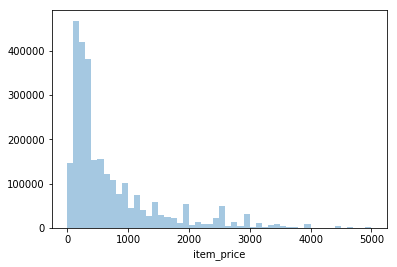

In [33]:
sns.distplot(train_df.loc[train_df['item_price']<5000, 'item_price'], kde=False)

There is an entry with negative price:

In [34]:
train_df.loc[train_df['item_price']<0, :]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category,item_subcategory,city,shop_type,rate,price_usd,revenue,revenue_usd
1267109,2013-05-15,4,32,2973,-1.0,1.0,dmc devil may cry,Игры,PS3,москва,тц,31.45,-0.031797,-1.0,-0.031797


Filling it with the mean price of this particular item:

In [35]:
train_df.loc[train_df['item_price']<0, 'item_price'] = train_df.loc[
    train_df['item_id']==train_df.loc[train_df['item_price']<0,
                                      'item_id'].values[0], 'item_price'].mean()

Replotting in log10 scale:

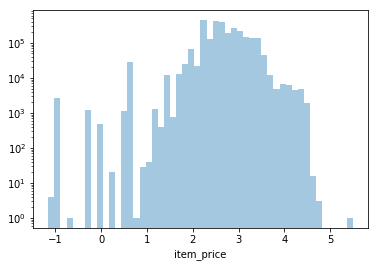

In [36]:
sns.distplot(np.log10(train_df['item_price']), kde=False)
plt.yscale('log')

In [37]:
train_df = train_df.loc[(train_df['item_price']<10**5), :]

### __Item count per day__ distribution:

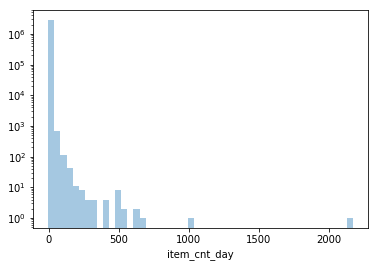

In [38]:
sns.distplot(train_df.loc[(train_df['item_cnt_day']<10000)&(train_df['item_cnt_day']>-5),
                          'item_cnt_day'], kde=False)
plt.yscale('log')

In [39]:
train_df = train_df.loc[(train_df['item_cnt_day']<750), :]

### __Item counts versus item prices__

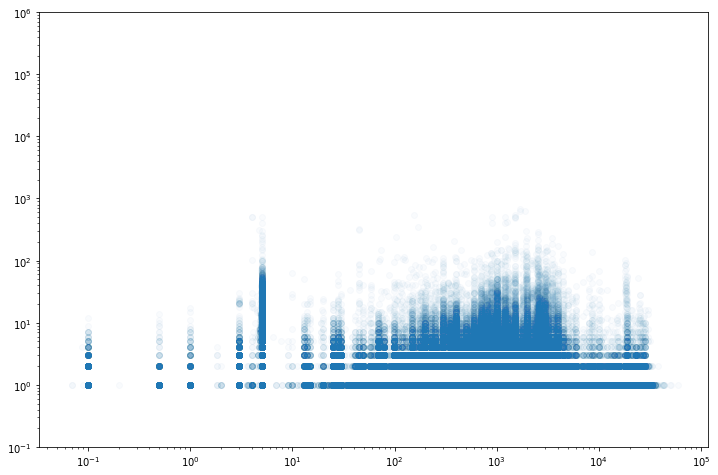

In [40]:
plt.figure(figsize=(12, 8))
plt.scatter(train_df['item_price'], train_df['item_cnt_day'], alpha=0.025)
plt.xscale('log')
plt.yscale('log')
plt.ylim((1e-1, 1e6))
plt.show()

Around 90% of all daily sales include only one item:

In [41]:
train_df.loc[train_df['item_cnt_day']==1, :].shape[0] / train_df.shape[0]

0.8962063976098381

In [42]:
t_df = train_df.groupby(['date_block_num', 'item_id', 'shop_id'])[['item_cnt_day']].sum()
t_df = t_df.reset_index().rename(columns={'item_cnt_day': 'item_cnt_month'})

In case of monthly sales, this value is of around 70%:

In [43]:
t_df.loc[t_df['item_cnt_month']==1, :].shape[0] / t_df.shape[0]

0.6644081798614315

However, in 95% of all cases, the monthly sales volume is not greater than 5:

In [44]:
t_df.loc[t_df['item_cnt_month']<=5, :].shape[0] / t_df.shape[0]

0.9448611250052439

In [45]:
del t_df
gc.collect()

28490

### __Total sales behaviour depending on month/year__

In [46]:
t_df = train_df[['item_cnt_day', 'date']].copy()

In [47]:
t_df['month'] = t_df['date'].dt.month
t_df['year'] = t_df['date'].dt.year

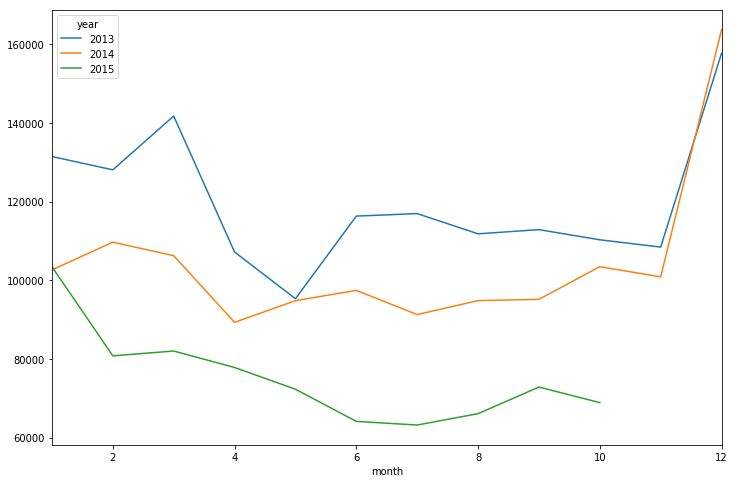

In [48]:
data = t_df.groupby(
    ['year','month']).agg({'item_cnt_day': np.sum}).reset_index().pivot(
    index='month', columns='year', values='item_cnt_day')
data.plot(figsize=(12, 8))

In [49]:
del t_df, data
gc.collect()

12

### __Seasonal decomposition:__

In [50]:
temp_sum = train_df.groupby(['date_block_num'])[['item_cnt_day', 'revenue', 'revenue_usd']].sum()
temp_sum = temp_sum.reset_index().rename(columns={'item_cnt_day': 'item_cnt_month'})

Cumulative __sales volume__:

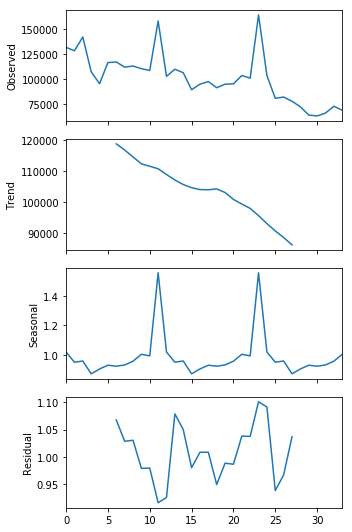

In [51]:
rcParams['figure.figsize'] = 5, 7.5
decomposition = sm.tsa.seasonal_decompose(temp_sum['item_cnt_month'], freq=12, model='multiplicative')
fig = decomposition.plot()
plt.show()

Cumulative __revenue__:

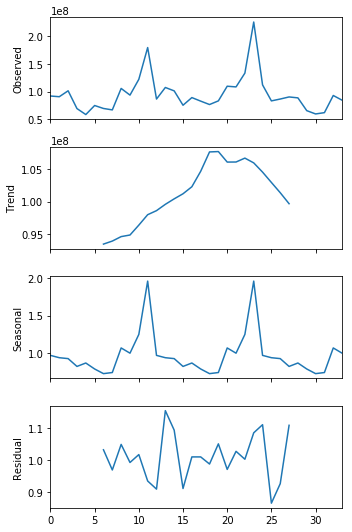

In [52]:
decomposition = sm.tsa.seasonal_decompose(temp_sum['revenue'], freq=12, model='multiplicative')
fig = decomposition.plot()
plt.show()

In [53]:
temp_mean = train_df.groupby(['date_block_num'])[['item_cnt_day', 'revenue', 'revenue_usd']].mean()
temp_mean = temp_mean.reset_index().rename(columns={'item_cnt_day': 'item_cnt_mean',
                                                    'revenue': 'av_revenue'})

Average __sales volume__:

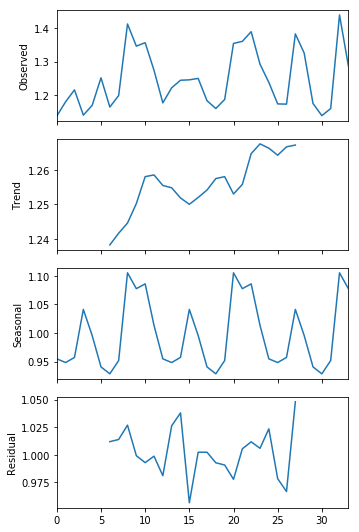

In [54]:
decomposition = sm.tsa.seasonal_decompose(temp_mean['item_cnt_mean'], freq=12, model='multiplicative')
fig = decomposition.plot()
plt.show()

Average __revenue__:

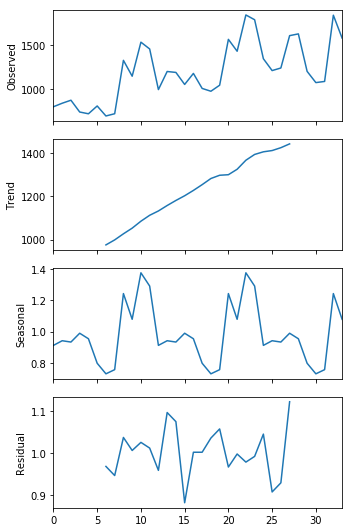

In [55]:
decomposition = sm.tsa.seasonal_decompose(temp_mean['av_revenue'], freq=12, model='multiplicative')
fig = decomposition.plot()
plt.show()

There is a __clear seasonality__ in both overall amount of sales and average sales per day. Moreover, there seems to be a __negative trend__ for the former and a __positive one__ for the latter.  
If one looks at the __revenues__, it can be seen that even though the __seasonality__ persists here, there is __no clear trend__ in case of cumulative value. The __average revenues__ follow the behaviour of the average number of sales.

In [56]:
del temp_mean, temp_sum
gc.collect()

29996

### Sales distributions by __shop_id__:

In [57]:
shop_sum = train_df.groupby(['shop_id'], as_index=False)[['item_cnt_day', 'revenue']].sum()
shop_mean = train_df.groupby(['shop_id'], as_index=False)[['item_cnt_day', 'revenue']].mean()

In [58]:
shop_sum = shop_sum.rename(columns={'item_cnt_day': 'item_cnt_sum'}).sort_values(by='item_cnt_sum')
shop_mean = shop_mean.rename(columns={'item_cnt_day': 'item_cnt_mean'})

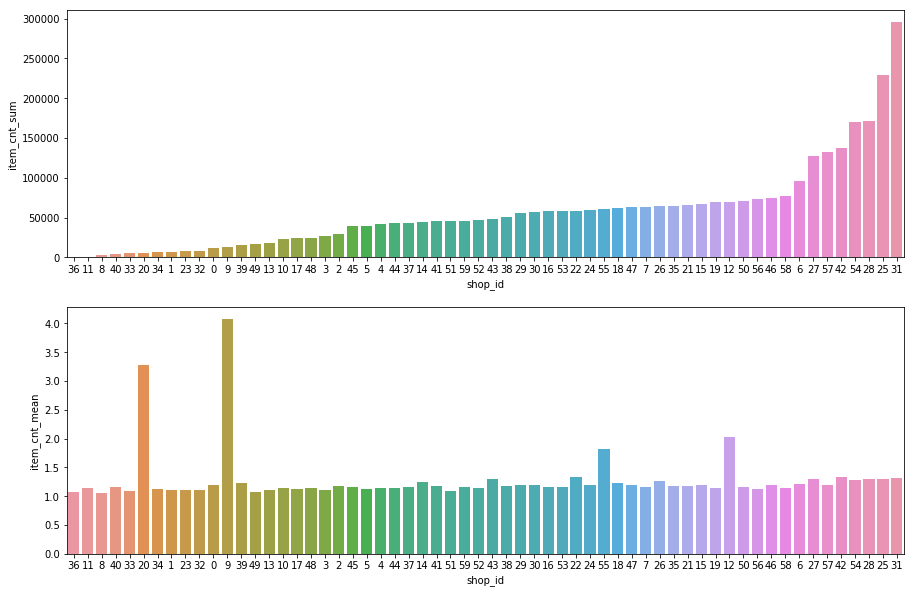

In [59]:
f, axes = plt.subplots(2, 1, figsize=(15, 10))
sns.barplot(x=shop_sum['shop_id'], y=shop_sum['item_cnt_sum'], ax=axes[0], order=shop_sum['shop_id'])
sns.barplot(x=shop_mean['shop_id'], y=shop_mean['item_cnt_mean'], ax=axes[1], order=shop_sum['shop_id'])
plt.show()

Whereas the average number daily sales is around 1 for all the shops, there are several shops having larger cumulative amount of sales.

As one can see, these are mostly located in Moscow and its outskirts:

In [60]:
pd.merge(shop_sum, shop_df).tail()

,shop_id,item_cnt_sum,revenue,shop_name,city,shop_type
55,42,137989.0,1.454613e+08,"СПб ТК ""Невский Центр""",спб,тк
56,54,170551.0,1.315888e+08,"Химки ТЦ ""Мега""",химки,тц
57,28,170961.0,1.491373e+08,"Москва ТЦ ""МЕГА Теплый Стан"" II",москва,тц
58,25,229700.0,2.076013e+08,"Москва ТРК ""Атриум""",москва,трк
59,31,295745.0,2.254598e+08,"Москва ТЦ ""Семеновский""",москва,тц


In [61]:
del shop_sum, shop_mean
gc.collect()

15

### Sales distribution by __item_category__:

In [62]:
item_sum = train_df.groupby(['item_category'], as_index=False)[['item_cnt_day', 'revenue']].sum()
item_mean = train_df.groupby(['item_category'], as_index=False)[['item_cnt_day', 'revenue']].mean()

In [63]:
item_sum = item_sum.rename(columns={'item_cnt_day': 'item_cnt_sum',
                                   'revenue': 'revenue_sum'}).sort_values(by='item_cnt_sum')
item_mean = item_mean.rename(columns={'item_cnt_day': 'item_cnt_mean',
                                     'revenue': 'av_revenue'})

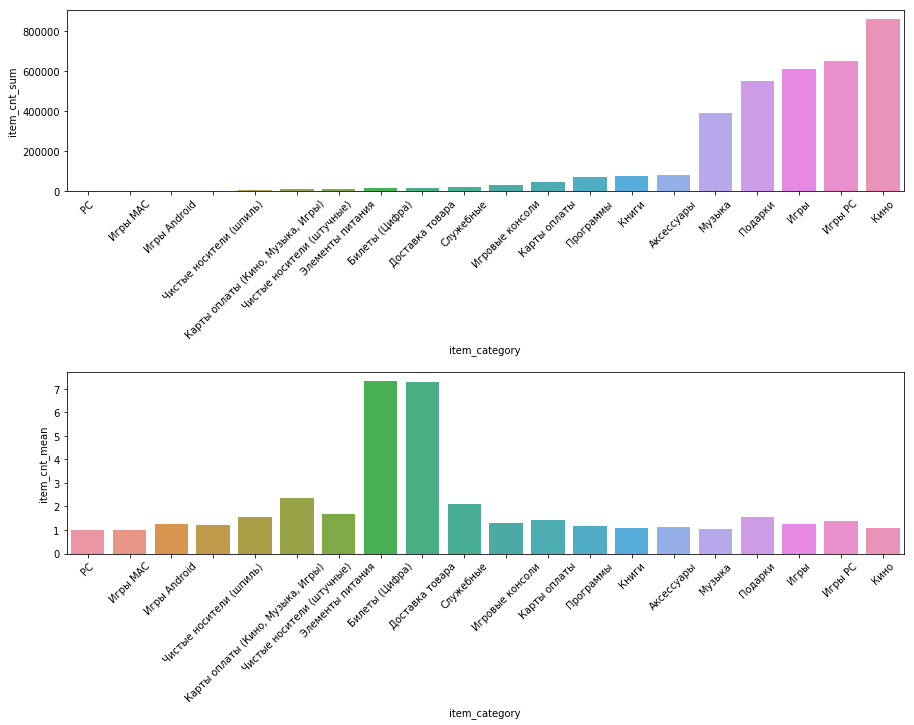

In [64]:
f, axes = plt.subplots(2, 1, figsize=(15, 10), sharex=False)
sns.barplot(x=item_sum['item_category'], y=item_sum['item_cnt_sum'], ax=axes[0],
            order=item_sum['item_category'])
sns.barplot(x=item_mean['item_category'], y=item_mean['item_cnt_mean'], ax=axes[1],
            order=item_sum['item_category'])
plt.subplots_adjust(hspace=1)
for ax in axes:
    plt.sca(ax)
    plt.xticks(rotation=45)
plt.show()

There are top 5 product categories dominating the overall sales volume.

Taking a look at what's happening inside the top category (__'Movies'__):

In [65]:
movies_df = train_df.loc[train_df['item_category']=='Кино',
             :].groupby('item_id', as_index=False).sum()[['item_id', 'item_cnt_day']]

In [66]:
top20_movies = pd.merge(movies_df, item_df).sort_values(by='item_cnt_day', ascending=False).head(20)

In [67]:
top20_movies = top20_movies.rename(columns={'item_cnt_day': 'item_cnt_sum'})

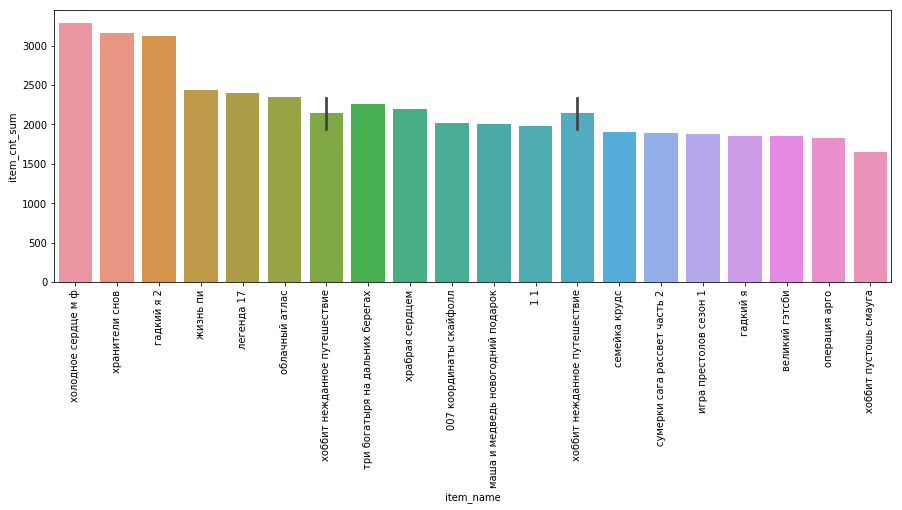

In [68]:
plt.figure(figsize=(15, 5))
sns.barplot(x=top20_movies['item_name'], y=top20_movies['item_cnt_sum'],
            order=top20_movies['item_name'])
plt.xticks(rotation=90)
plt.show()

The distribution of the sales in the top category ('Movies') is monotonous, no peculiarities are observed

In [69]:
del top20_movies
gc.collect()

28857

### __Revenues__ distribution by category:

In [70]:
item_sum = item_sum.sort_values(by='revenue_sum')

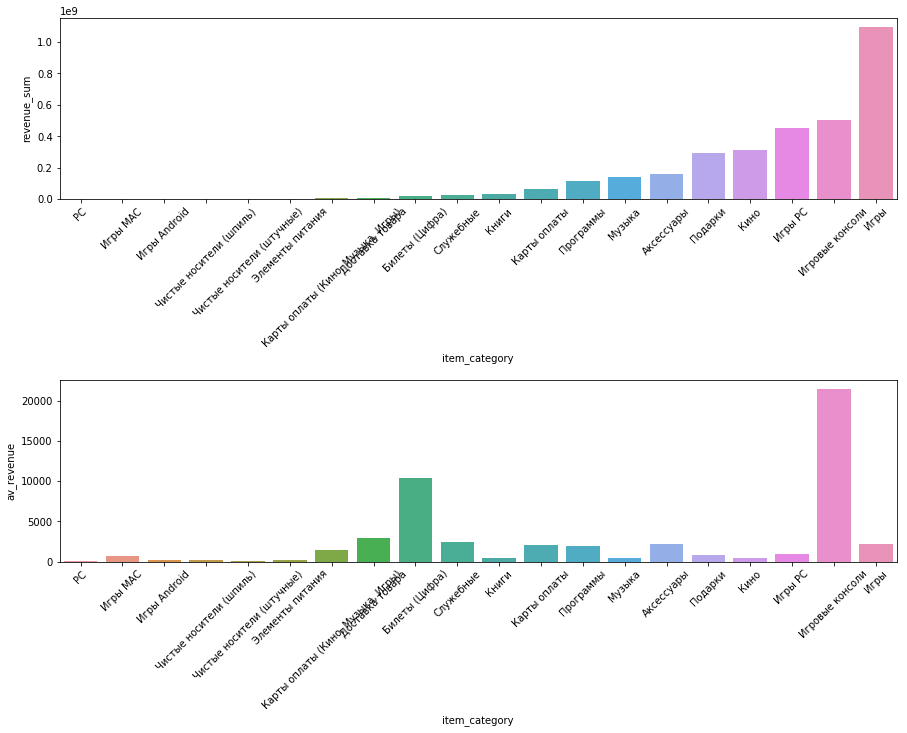

In [71]:
f, axes = plt.subplots(2, 1, figsize=(15, 10), sharex=False)
sns.barplot(x=item_sum['item_category'], y=item_sum['revenue_sum'], ax=axes[0],
            order=item_sum['item_category'])
sns.barplot(x=item_mean['item_category'], y=item_mean['av_revenue'], ax=axes[1],
            order=item_sum['item_category'])
plt.subplots_adjust(hspace=1)
for ax in axes:
    plt.sca(ax)
    plt.xticks(rotation=45)
plt.show()

Even though the volume is mostly determined by one set of categories, the situation in case of revenue is slightly different. One can see, for instance that __'Games'__ becomes the top category instead of __'Movies'__. The __'Game consoles'__, despite having relatively low volume, gets the second place due to its high price.

In [72]:
del item_sum, item_mean
gc.collect()

9906

Taking a look at what's happening __inside the top categories__:

In [73]:
games_df = train_df.loc[train_df['item_category']=='Игры',
             :].groupby('item_id', as_index=False).sum()[['item_id', 'revenue', 'item_cnt_day']]

In [74]:
top20_games = pd.merge(games_df, item_df).sort_values(by='revenue', ascending=False).head(20)

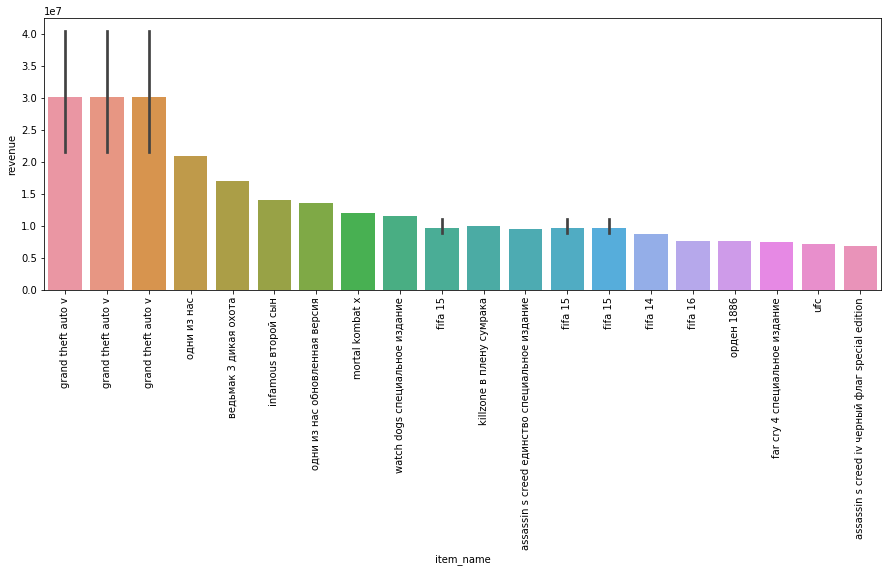

In [75]:
plt.figure(figsize=(15, 5))
sns.barplot(x=top20_games['item_name'], y=top20_games['revenue'],
            order=top20_games['item_name'])
plt.xticks(rotation=90)
plt.show()

In [76]:
consoles_df = train_df.loc[train_df['item_category']=='Игровые консоли',
             :].groupby('item_id', as_index=False).sum()[['item_id', 'revenue', 'item_cnt_day']]

In [77]:
top20_consoles = pd.merge(consoles_df, item_df).sort_values(by='revenue', ascending=False).head(20)

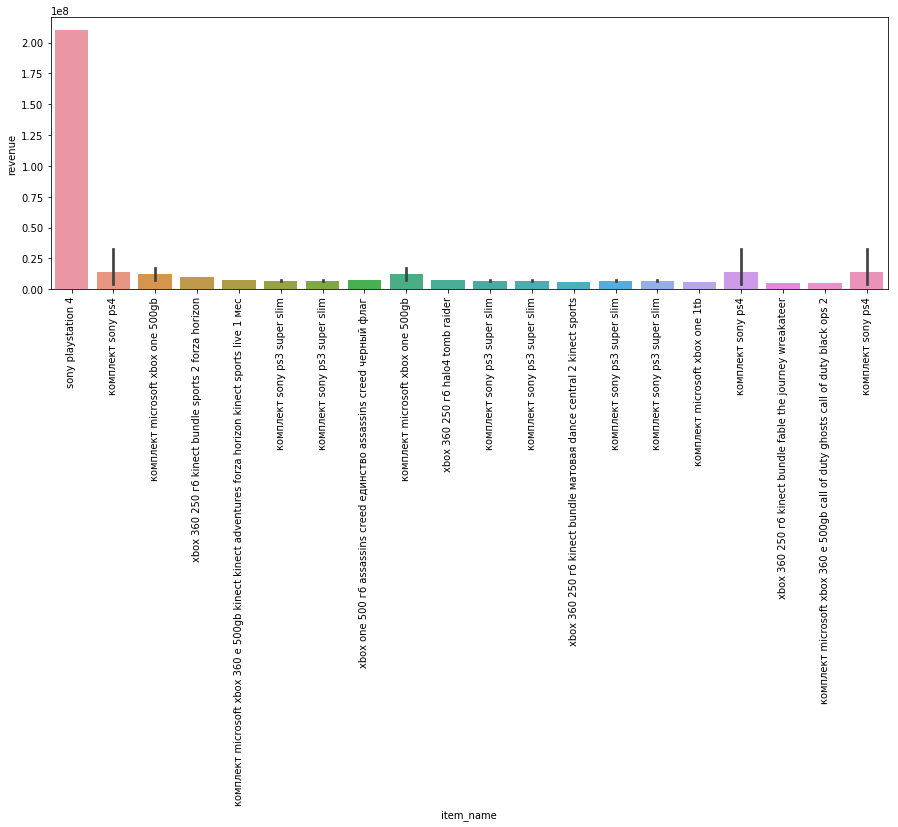

In [78]:
plt.figure(figsize=(15, 5))
sns.barplot(x=top20_consoles['item_name'], y=top20_consoles['revenue'],
            order=top20_consoles['item_name'])
plt.xticks(rotation=90)
plt.show()

## Preparing target variable:

Looking at the test set:

In [79]:
test_df.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [80]:
test_df.shape

(214200, 3)

In [81]:
pd.DataFrame(product(*[test_df['shop_id'].unique(), test_df['item_id'].unique()])).shape

(214200, 2)

Strangely enough, the test set contains a product (i.e. all possible combinations) of all the unique shops and items in it. Seems logical to do something similar with the train set...

### Including all possible combinations of unique shops/items for each month in the train set:

In [82]:
gr_date = train_df.groupby('date_block_num')

In [83]:
t_d = gr_date.apply(lambda x: product(*[[x.name], x['shop_id'].unique(), x['item_id'].unique()]))

In [84]:
all_vals = pd.DataFrame()
for t in tqdm(t_d.values):
    all_vals = pd.concat([all_vals, pd.DataFrame(t)], axis=0)

In [85]:
all_vals.columns = ['date_block_num', 'shop_id', 'item_id']
all_vals.head()

,date_block_num,shop_id,item_id
0,0,59,22154
1,0,59,2746
2,0,59,2847
3,0,59,2848
4,0,59,2854


Adding test shops/items @ last month:

In [86]:
test_vals = pd.DataFrame()
test_vals['shop_id'] = test_df['shop_id'].copy()
test_vals['item_id'] = test_df['item_id'].copy()
test_vals['date_block_num'] = 34

In [87]:
all_vals = pd.concat([all_vals, test_vals], axis=0)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


### Target variable:

In [88]:
gr_month = train_df.groupby(['shop_id', 'item_id', 'date_block_num'])

In [89]:
month_sum = gr_month.sum()

In [90]:
month_sum.shape

(1549415, 6)

In [91]:
month_sum.head()

item_price  item_cnt_day    rate   price_usd  \
shop_id item_id date_block_num                                                 
0       30      1                   2385.0          31.0  272.60   78.744539   
        31      1                   3038.0          11.0  212.17  100.234346   
        32      0                    884.0           6.0  120.53   29.337544   
                1                   1547.0          10.0  211.06   51.309233   
        33      0                   1041.0           3.0   90.60   34.470247   

                                revenue  revenue_usd  
shop_id item_id date_block_num                        
0       30      1                8215.0   271.611203  
        31      1                4774.0   157.860917  
        32      0                1326.0    43.949115  
                1                2210.0    73.280381  
        33      0                1041.0    34.470247

In [92]:
month_sum = month_sum.rename(columns={'item_cnt_day':'item_cnt_month'})

In [93]:
month_sum.head()

item_price  item_cnt_month    rate  \
shop_id item_id date_block_num                                       
0       30      1                   2385.0            31.0  272.60   
        31      1                   3038.0            11.0  212.17   
        32      0                    884.0             6.0  120.53   
                1                   1547.0            10.0  211.06   
        33      0                   1041.0             3.0   90.60   

                                 price_usd  revenue  revenue_usd  
shop_id item_id date_block_num                                    
0       30      1                78.744539   8215.0   271.611203  
        31      1               100.234346   4774.0   157.860917  
        32      0                29.337544   1326.0    43.949115  
                1                51.309233   2210.0    73.280381  
        33      0                34.470247   1041.0    34.470247

Clipping target variable according to the competition rules:

In [94]:
month_sum['item_cnt_month'] = month_sum['item_cnt_month'].clip(0, 20)

In [95]:
month_sum = month_sum.reset_index()[['shop_id', 'item_id',
                                     'item_cnt_month', 'date_block_num',
                                    'revenue', 'revenue_usd']]

Adding all the zero values:

In [96]:
month_sum = pd.merge(all_vals, month_sum,
                     on=['shop_id','item_id', 'date_block_num'],
                     how='left').fillna(0)

In [97]:
month_sum.head()

,date_block_num,item_id,shop_id,item_cnt_month,revenue,revenue_usd
0,0,22154,59,1.0,999.0,33.101392
1,0,2746,59,9.0,2571.0,84.993986
2,0,2847,59,2.0,3398.0,112.853483
3,0,2848,59,2.0,198.0,6.575924
4,0,2854,59,3.0,1347.0,44.543739


In [98]:
month_sum.shape

(10985992, 6)

Merging with the shop and item datasets:

In [99]:
month_sum = reduce_mem_usage(month_sum)
shop_df = reduce_mem_usage(shop_df)
item_df = reduce_mem_usage(item_df)

Mem. usage decreased to 230.50 Mb (60.7% reduction)
Mem. usage decreased to  0.00 Mb (20.5% reduction)
Mem. usage decreased to  0.74 Mb (27.1% reduction)


In [100]:
month_sum = month_sum.merge(shop_df[['shop_id', 'city', 'shop_type']],
                            how='left', on=['shop_id'])

In [101]:
alles = month_sum.merge(item_df, how='left', on=['item_id'])

In [102]:
alles.head()

,date_block_num,item_id,shop_id,item_cnt_month,revenue,revenue_usd,city,shop_type,item_name,item_category_id,item_category,item_subcategory
0,0,22154,59,1.0,999.0,33.101391,ярославль,тц,явление 2012,37,Кино,Blu-Ray
1,0,2746,59,9.0,2571.0,84.993988,ярославль,тц,dead space 2,30,Игры PC,Стандартные издания
2,0,2847,59,2.0,3398.0,112.853485,ярославль,тц,disney история игрушек парк развлечений,23,Игры,XBOX 360
3,0,2848,59,2.0,198.0,6.575924,ярославль,тц,disney мир героев,30,Игры PC,Стандартные издания
4,0,2854,59,3.0,1347.0,44.543739,ярославль,тц,disney храбрая сердцем,30,Игры PC,Стандартные издания


Average USD/RUB exchange rate:

In [103]:
exch_rate['month'] = exch_rate['date'].dt.month
exch_rate['year'] = exch_rate['date'].dt.year

In [104]:
temp_mean = exch_rate.groupby(['year', 'month']).mean().reset_index()

In [105]:
temp_mean['date_block_num'] = range(35)

In [106]:
temp_mean = reduce_mem_usage(temp_mean)

Mem. usage decreased to  0.00 Mb (72.9% reduction)


In [107]:
temp_mean.head()

,year,month,rate,date_block_num
0,2013,1,30.234375,0
1,2013,2,30.187500,1
2,2013,3,30.796875,2
3,2013,4,31.343750,3
4,2013,5,31.343750,4


In [108]:
alles = alles.merge(temp_mean, how='left', on=['date_block_num'])

## Feature engineering

### Lagging prices:

Borrowed from https://www.kaggle.com/dlarionov/feature-engineering-xgboost:

In [109]:
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

In [110]:
gr = train_df.groupby(['item_id', 'shop_id', 'date_block_num'])

In [111]:
m_price = gr.mean()

In [112]:
m_price = m_price.rename(columns={'revenue': 'av_revenue', 'revenue_usd': 'av_revenue_usd', 
                                 'item_cnt_day': 'av_item_cnt_day', 'item_price': 'av_item_price',
                                 'price_usd': 'av_price_usd'})

In [113]:
m_price = m_price.drop(['rate'], axis=1)

Number of active days (where a purchase has been done) for a particular item-shop pair:

In [114]:
m_price['item_purchase_days'] = gr.count()['date']
m_price = m_price.reset_index()
m_price = reduce_mem_usage(m_price)

Mem. usage decreased to 25.12 Mb (76.4% reduction)


In [115]:
m_price.head()

,item_id,shop_id,date_block_num,av_item_price,av_item_cnt_day,av_price_usd,av_revenue,av_revenue_usd,item_purchase_days
0,0,54,20,58.0,1.0,1.553711,58.0,1.553711,1
1,1,55,15,4488.0,1.0,126.875000,4490.0,126.875000,2
2,1,55,18,4488.0,1.0,130.500000,4490.0,130.500000,1
3,1,55,19,4488.0,1.0,125.375000,4490.0,125.375000,1
4,1,55,20,4488.0,1.0,119.437500,4490.0,119.437500,1


Average number of items bought (on active days):

In [116]:
m_price['av_item_cnt_day'] /= m_price['item_purchase_days']

Mean item price over all shops and months and current deviation from its value:

In [117]:
m_group = m_price.groupby(['item_id'], as_index=False)['av_item_price'].mean()

In [118]:
m_group = m_group.rename(columns={'av_item_price': 'mean_price'})

In [119]:
m_price = pd.merge(all_vals, m_price,
                     on=['shop_id','item_id', 'date_block_num'],
                     how='left').fillna(0)

In [120]:
m_price = pd.merge(m_price, m_group, on=['item_id'], how='left')

In [121]:
m_price['price_dev'] = (m_price['av_item_price'] - m_price['mean_price']) / m_price['mean_price']

Lag everything:

In [122]:
m_price = lag_feature(m_price, [1, 2, 3, 6, 12], 'item_purchase_days')
m_price = lag_feature(m_price, [1, 2, 3, 6, 12], 'av_item_cnt_day')
m_price = lag_feature(m_price, [1, 2, 3], 'av_item_price')
m_price = lag_feature(m_price, [1, 2, 3], 'av_price_usd')
m_price = lag_feature(m_price, [1, 2, 3], 'price_dev')

In [123]:
m_price = lag_feature(m_price, [1, 2, 3], 'av_revenue')
m_price = lag_feature(m_price, [1, 2, 3], 'av_revenue_usd')

In [124]:
m_price.head()

,date_block_num,item_id,shop_id,av_item_price,av_item_cnt_day,av_price_usd,av_revenue,av_revenue_usd,item_purchase_days,mean_price,...,av_price_usd_lag_3,price_dev_lag_1,price_dev_lag_2,price_dev_lag_3,av_revenue_lag_1,av_revenue_lag_2,av_revenue_lag_3,av_revenue_usd_lag_1,av_revenue_usd_lag_2,av_revenue_usd_lag_3
0,0,22154,59,999.00,1.000000,33.093750,999.000000,33.093750,1.0,690.5000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,2746,59,286.25,0.183716,9.453125,367.285706,12.140625,7.0,265.7500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,2847,59,1699.00,0.500000,56.437500,1699.000000,56.437500,2.0,1414.0000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,2848,59,99.00,0.500000,3.287109,99.000000,3.287109,2.0,96.4375,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,2854,59,449.00,0.750000,14.851562,673.500000,22.265625,2.0,237.2500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


"Projected" values: silly linear extrapolation to the next month:

In [125]:
m_price['proj_av_revenue'] = 2 * (m_price['av_revenue_lag_1'] -
                           m_price['av_revenue_lag_2']) + m_price['av_revenue_lag_2']

m_price['proj_av_revenue_2'] = 3 * (m_price['av_revenue_lag_1'] - 
                             m_price['av_revenue_lag_3']) / 2 + m_price['av_revenue_lag_3']

In [126]:
m_price['proj_price'] = 2 * (m_price['av_item_price_lag_1'] - 
                             m_price['av_item_price_lag_2']) + m_price['av_item_price_lag_2']

m_price['proj_price_2'] = 3 * (m_price['av_item_price_lag_1'] - 
                               m_price['av_item_price_lag_3']) / 2 + m_price['av_item_price_lag_3']

In [127]:
cols = [c for c in m_price.columns if c not in ['item_cnt_day', 'rate',
                                                'av_item_price', 'av_price_usd',
                                                'revenue', 'revenue_usd', 'item_purchase_days',
                                                'av_item_cnt_day', 'price_dev',
                                               'av_revenue', 'av_revenue_usd']]

In [128]:
m_price = reduce_mem_usage(m_price.loc[:, cols])

Mem. usage decreased to 984.84 Mb (28.8% reduction)


In [129]:
alles = pd.merge(alles, m_price,
        on=['item_id', 'date_block_num', 'shop_id'], how='left')

In [130]:
del m_price
gc.collect()

10378

### Lagging target variable:

In [131]:
alles = lag_feature(alles, [1, 2, 3, 6, 12], 'item_cnt_month')

Linear extrapolation to the next month:

In [132]:
alles['proj_item_cnt'] = 2 * (alles['item_cnt_month_lag_1'] - 
                              alles['item_cnt_month_lag_2']) + alles['item_cnt_month_lag_2']

alles['proj_item_cnt_2'] = 3 * (alles['item_cnt_month_lag_1'] -
                                alles['item_cnt_month_lag_3']) / 2 + alles['item_cnt_month_lag_3']

alles['proj_item_cnt_12'] = 12 * (alles['item_cnt_month_lag_1'] - 
                                  alles['item_cnt_month_lag_12']) / 11 + alles['item_cnt_month_lag_12']

Averaging the values based on the extrapolation over 1, 2, and 11 months:

In [133]:
alles['mean_proj_item_cnt'] = np.mean([alles['proj_item_cnt'],
                                       alles['proj_item_cnt_2'], alles['proj_item_cnt_12']], axis=0)

### Lagging revenues:

In [134]:
alles = lag_feature(alles, [1, 2, 3, 6, 12], 'revenue')
alles = lag_feature(alles, [1, 2, 3, 6, 12], 'revenue_usd')

Linear extrapolation:

In [135]:
alles['proj_monthly_revenue'] = 2 * (alles['revenue_lag_1'] - 
                                     alles['revenue_lag_2']) + alles['revenue_lag_2']

alles['proj_monthly_revenue_2'] = 3 * (alles['revenue_lag_1'] - 
                                       alles['revenue_lag_3']) / 2 + alles['revenue_lag_3']

alles['proj_monthly_revenue_12'] = 12 * (alles['revenue_lag_1'] - 
                                         alles['revenue_lag_12']) / 11 + alles['revenue_lag_12']

Averaging the extrapolated values:

In [136]:
alles['mean_proj_revenue'] = np.mean([alles['proj_monthly_revenue'],
                                       alles['proj_monthly_revenue_2'],
                                      alles['proj_monthly_revenue_12']], axis=0)

In [137]:
alles = alles.drop(['revenue', 'revenue_usd'], axis=1)

### Shop purchases per month (independent of the item_id):

In [138]:
gr_shop = train_df.groupby(['shop_id', 'date_block_num'])

In [139]:
pdf = pd.merge(all_vals, gr_shop.count()['date'], on=['shop_id', 'date_block_num'], how='left')

In [140]:
pdf = pdf.rename(columns={'date':'purchases_per_month'})[['date_block_num',
                                                         'shop_id',
                                                          'purchases_per_month']].drop_duplicates()

In [141]:
tmp = pdf[['date_block_num','shop_id', 'purchases_per_month']]
shifted = tmp.copy()
shifted.columns = ['date_block_num','shop_id', 'purchases_per_month'+'_lag_'+str(1)]
shifted['date_block_num'] += 1
pdf = pd.merge(pdf, shifted, on=['date_block_num','shop_id'], how='left')

In [142]:
pdf = reduce_mem_usage(pdf)

Mem. usage decreased to  0.02 Mb (65.0% reduction)


In [143]:
pdf = pdf.drop(['purchases_per_month'], axis=1)

In [144]:
alles = pd.merge(alles, pdf, on=['shop_id', 'date_block_num'], how='left')

### Shop active months:

In [145]:
cc_df = pd.DataFrame(gr_shop.mean().groupby('shop_id').cumcount(), columns=['active_months'])
cc_df = cc_df.reset_index()

In [146]:
cc_df = pd.merge(all_vals[['date_block_num', 'shop_id']], cc_df,
                 on=['date_block_num', 'shop_id'], how='left').drop_duplicates()

In [147]:
tmp = cc_df[['date_block_num','shop_id', 'active_months']]
for i in [1]:
    shifted = tmp.copy()
    shifted.columns = ['date_block_num','shop_id', 'active_months'+'_lag_'+str(i)]
    shifted['date_block_num'] += i
    cc_df = pd.merge(cc_df, shifted, on=['date_block_num','shop_id'], how='left')

In [148]:
cc_df = cc_df.drop(['active_months'], axis=1)

In [149]:
for i in [1]:
    cc_df['active_months_lag_'+str(i)] += i
    cc_df['active_months_lag_'+str(i)] = cc_df['active_months_lag_'+str(i)].fillna(0).astype('int')

In [150]:
cc_df = reduce_mem_usage(cc_df)

Mem. usage decreased to  0.02 Mb (65.6% reduction)


In [151]:
alles = pd.merge(alles, cc_df, on=['shop_id', 'date_block_num'], how='left')

### Item active months:

In [152]:
gr_item = train_df.groupby(['item_id', 'date_block_num'])

In [153]:
cc_df = pd.DataFrame(gr_item.mean().groupby('item_id').cumcount(), columns=['item_active_months'])
cc_df = cc_df.reset_index()

In [154]:
cc_df = pd.merge(all_vals[['date_block_num', 'item_id']], cc_df,
                 on=['date_block_num', 'item_id'], how='left').drop_duplicates()

In [155]:
tmp = cc_df[['date_block_num','item_id', 'item_active_months']]
for i in [1]:
    shifted = tmp.copy()
    shifted.columns = ['date_block_num','item_id', 'item_active_months'+'_lag_'+str(i)]
    shifted['date_block_num'] += i
    cc_df = pd.merge(cc_df, shifted, on=['date_block_num','item_id'], how='left')

In [156]:
cc_df = cc_df.drop(['item_active_months'], axis=1)

In [157]:
for i in [1]:
    cc_df['item_active_months_lag_'+str(i)] += i
    cc_df['item_active_months_lag_'+str(i)] = cc_df['item_active_months_lag_'+str(i)].fillna(0).astype('int')

In [158]:
cc_df = reduce_mem_usage(cc_df)

Mem. usage decreased to  2.70 Mb (62.5% reduction)


In [159]:
alles = pd.merge(alles, cc_df, on=['item_id', 'date_block_num'], how='left')

### Shop+item active months:

In [160]:
cc_df = pd.DataFrame(gr.mean().groupby(['shop_id','item_id']).cumcount(), columns=['shop_item_active_months'])
cc_df = cc_df.reset_index()

In [161]:
cc_df = pd.merge(all_vals, cc_df,
                 on=['date_block_num', 'shop_id', 'item_id'], how='left').drop_duplicates()

In [162]:
cc_df = lag_feature(cc_df, [1], 'shop_item_active_months')

In [163]:
for i in [1]:
    cc_df['shop_item_active_months_lag_'+str(i)] += i
    cc_df['shop_item_active_months_lag_'+str(i)] = cc_df['shop_item_active_months_lag_'
                                                         +str(i)].fillna(0).astype('int')

In [164]:
cc_df = cc_df.drop(['shop_item_active_months'], axis=1)

In [165]:
cc_df = reduce_mem_usage(cc_df)

Mem. usage decreased to 136.20 Mb (67.5% reduction)


In [166]:
alles = pd.merge(alles, cc_df, on=['item_id', 'shop_id', 'date_block_num'], how='left')

### Cumulative shop revenue:

In [167]:
cum_revs = gr_shop.mean()

In [168]:
cum_revs = cum_revs[['revenue', 'revenue_usd']]

In [169]:
cum_revs = cum_revs.reset_index()

In [170]:
cum_revs = pd.merge(all_vals[['shop_id', 'date_block_num']],
         cum_revs, on=['shop_id', 'date_block_num'], how='left').drop_duplicates()

In [171]:
cum_revs['c_shop_revenue_usd'] = cum_revs.groupby('shop_id')['revenue_usd'].cumsum().values
cum_revs['c_shop_revenue'] = cum_revs.groupby('shop_id')['revenue'].cumsum().values

In [172]:
tmp = cum_revs[['date_block_num','shop_id', 'c_shop_revenue']]
shifted = tmp.copy()
shifted.columns = ['date_block_num','shop_id', 'c_shop_revenue'+'_lag_'+str(1)]
shifted['date_block_num'] += 1
cum_revs = pd.merge(cum_revs, shifted, on=['date_block_num','shop_id'], how='left')

In [173]:
tmp = cum_revs[['date_block_num','shop_id', 'c_shop_revenue_usd']]
shifted = tmp.copy()
shifted.columns = ['date_block_num','shop_id', 'c_shop_revenue_usd'+'_lag_'+str(1)]
shifted['date_block_num'] += 1
cum_revs = pd.merge(cum_revs, shifted, on=['date_block_num','shop_id'], how='left')

In [174]:
cum_revs = reduce_mem_usage(cum_revs)

Mem. usage decreased to  0.04 Mb (63.9% reduction)


In [175]:
alles = pd.merge(alles, cum_revs[['shop_id', 'date_block_num',
                                  'c_shop_revenue_lag_1', 'c_shop_revenue_usd_lag_1']],
                                   on=['shop_id', 'date_block_num'], how='left')

### Cumulative shop revenue based on a particular item:

In [176]:
cum_revs = gr.mean()

In [177]:
cum_revs = cum_revs[['revenue', 'revenue_usd']]

In [178]:
cum_revs = cum_revs.reset_index()

In [179]:
cum_revs = pd.merge(all_vals, cum_revs, on=['shop_id', 'date_block_num', 'item_id'], how='left')

In [180]:
cum_revs['revenue'] = cum_revs['revenue'].fillna(0)
cum_revs['revenue_usd'] = cum_revs['revenue_usd'].fillna(0)

In [181]:
cum_revs['c_revenue_usd'] = cum_revs.groupby('shop_id')['revenue_usd'].cumsum().values
cum_revs['c_revenue'] = cum_revs.groupby('shop_id')['revenue'].cumsum().values

In [182]:
cum_revs = lag_feature(cum_revs, [1], 'c_revenue')

In [183]:
cum_revs = lag_feature(cum_revs, [1], 'c_revenue_usd')

In [184]:
cum_revs = reduce_mem_usage(cum_revs)

Mem. usage decreased to 356.22 Mb (57.5% reduction)


In [185]:
alles = pd.merge(alles, cum_revs[['shop_id', 'date_block_num', 'item_id',
                                  'c_revenue_lag_1', 'c_revenue_usd_lag_1']],
                                   on=['shop_id', 'date_block_num', 'item_id'], how='left')

### Other mean values:

In [186]:
month_sum.head()

,date_block_num,item_id,shop_id,item_cnt_month,revenue,revenue_usd,city,shop_type
0,0,22154,59,1.0,999.0,33.101391,ярославль,тц
1,0,2746,59,9.0,2571.0,84.993988,ярославль,тц
2,0,2847,59,2.0,3398.0,112.853485,ярославль,тц
3,0,2848,59,2.0,198.0,6.575924,ярославль,тц
4,0,2854,59,3.0,1347.0,44.543739,ярославль,тц


Mean over __all shops and all items__ (fixed month):

In [187]:
group = month_sum.groupby(['date_block_num'])
gr_df = group.mean()
gr_df = gr_df.rename(columns={'item_cnt_month':'av_month'}).reset_index()

In [188]:
tmp = gr_df[['date_block_num', 'av_month']]
shifted = tmp.copy()
shifted.columns = ['date_block_num', 'av_month'+'_lag_'+str(1)]
shifted['date_block_num'] += 1
gr_df = pd.merge(gr_df, shifted, on=['date_block_num'], how='left')

In [189]:
gr_df = reduce_mem_usage(gr_df)

Mem. usage decreased to  0.00 Mb (52.3% reduction)


In [190]:
alles = pd.merge(alles, gr_df[['av_month_lag_1', 'date_block_num']], on=['date_block_num'], how='left')

Mean over __all shops__ (fixed item and month):

In [191]:
group = month_sum.groupby(['date_block_num', 'item_id'])
gr_df = group.mean()
gr_df = gr_df.rename(columns={'item_cnt_month':'av_month_item'}).reset_index()

In [192]:
tmp = gr_df[['date_block_num', 'item_id', 'av_month_item']]
shifted = tmp.copy()
shifted.columns = ['date_block_num', 'item_id', 'av_month_item'+'_lag_'+str(1)]
shifted['date_block_num'] += 1
gr_df = pd.merge(gr_df, shifted, on=['date_block_num', 'item_id'], how='left')

In [193]:
gr_df = reduce_mem_usage(gr_df)

Mem. usage decreased to  5.18 Mb (47.7% reduction)


In [194]:
alles = pd.merge(alles, gr_df[['av_month_item_lag_1', 'date_block_num', 'item_id']],
                 on=['date_block_num', 'item_id'], how='left')

Mean over __all items__ (fixed month and shop):

In [195]:
group = month_sum.groupby(['date_block_num', 'shop_id'])
gr_df = group.mean()
gr_df = gr_df.rename(columns={'item_cnt_month':'av_month_shop'}).reset_index()

In [196]:
tmp = gr_df[['date_block_num', 'shop_id', 'av_month_shop']]
shifted = tmp.copy()
shifted.columns = ['date_block_num', 'shop_id', 'av_month_shop'+'_lag_'+str(1)]
shifted['date_block_num'] += 1
gr_df = pd.merge(gr_df, shifted, on=['date_block_num', 'shop_id'], how='left')

In [197]:
gr_df = reduce_mem_usage(gr_df)

Mem. usage decreased to  0.03 Mb (54.5% reduction)


In [198]:
alles = pd.merge(alles, gr_df[['av_month_shop_lag_1', 'date_block_num', 'shop_id']],
                 on=['date_block_num', 'shop_id'], how='left')

Mean over __fixed category id and month__:

In [199]:
month_cat = pd.merge(month_sum, item_df)

In [200]:
group = month_cat.groupby(['date_block_num', 'item_category_id'])
gr_df = group.mean()
gr_df = gr_df.rename(columns={'item_cnt_month':'av_month_cat'}).reset_index()

In [201]:
tmp = gr_df[['date_block_num', 'item_category_id', 'av_month_cat']]
shifted = tmp.copy()
shifted.columns = ['date_block_num', 'item_category_id', 'av_month_cat'+'_lag_'+str(1)]
shifted['date_block_num'] += 1
gr_df = pd.merge(gr_df, shifted, on=['date_block_num', 'item_category_id'], how='left')

In [202]:
gr_df = reduce_mem_usage(gr_df)

Mem. usage decreased to  0.05 Mb (53.8% reduction)


In [203]:
alles = pd.merge(alles, gr_df[['av_month_cat_lag_1', 'date_block_num', 'item_category_id']],
                 on=['date_block_num', 'item_category_id'], how='left')

Mean over __fixed subcategory and month__:

In [204]:
group = month_cat.groupby(['date_block_num', 'item_subcategory'])
gr_df = group.mean()
gr_df = gr_df.rename(columns={'item_cnt_month':'av_month_subcat'}).reset_index()

In [205]:
tmp = gr_df[['date_block_num', 'item_subcategory', 'av_month_subcat']]
shifted = tmp.copy()
shifted.columns = ['date_block_num', 'item_subcategory', 'av_month_subcat'+'_lag_'+str(1)]
shifted['date_block_num'] += 1
gr_df = pd.merge(gr_df, shifted, on=['date_block_num', 'item_subcategory'], how='left')

In [206]:
gr_df = reduce_mem_usage(gr_df)

Mem. usage decreased to  0.06 Mb (45.0% reduction)


In [207]:
alles = pd.merge(alles, gr_df[['av_month_subcat_lag_1', 'date_block_num', 'item_subcategory']],
                 on=['date_block_num', 'item_subcategory'], how='left')

Mean over __all months__ (fixed shop/item pairs):

In [208]:
group = month_sum.groupby(['shop_id', 'item_id'])
gr_df = group.mean()
gr_df = gr_df.rename(columns={'item_cnt_month':'av_shop_item'}).reset_index()

In [209]:
gr_df = reduce_mem_usage(gr_df)

Mem. usage decreased to 14.23 Mb (61.8% reduction)


In [210]:
alles = pd.merge(alles, gr_df[['av_shop_item', 'shop_id', 'item_id']],
                 on=['shop_id', 'item_id'], how='left')

### First sales:

In [211]:
alles['first_sale'] = (alles['date_block_num'] -
                       alles.groupby(['item_id','shop_id'])['date_block_num'].transform('min'))
alles['item_first_sale'] = (alles['date_block_num'] -
                            alles.groupby('item_id')['date_block_num'].transform('min'))
alles['shop_first_sale'] = (alles['date_block_num'] -
                            alles.groupby('shop_id')['date_block_num'].transform('min'))

In [212]:
del train_df, month_sum, cum_revs, month_cat, shifted, tmp, gr_df, cc_df
gc.collect()

0

In [213]:
!mkdir data

In [214]:
with open('data/alles_final.pkl', 'wb') as handle:
    pickle.dump(alles, handle)

In [215]:
%reset -f

## Model

In [216]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import gc
from tqdm.notebook import tqdm
import pickle
import lightgbm as lgb
from lightgbm import LGBMRegressor
from lofo import LOFOImportance, FLOFOImportance, Dataset, plot_importance

from sklearn.metrics import (mean_squared_log_error, mean_squared_error,
                             mean_absolute_error)
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from sklearn.model_selection import train_test_split, KFold
import warnings

### Data preparation

In [217]:
alles = pd.read_pickle('data/alles_final.pkl')
alles = alles.drop(['mean_price', 'av_shop_item'], axis=1)

In [218]:
rows = alles['date_block_num'] > 11

In [219]:
alles[['item_name', 'item_category', 'item_subcategory', 'city', 'shop_type']] = \
alles[['item_name', 'item_category',
       'item_subcategory', 'city', 'shop_type']].apply(LabelEncoder().fit_transform)

Features found via LOFO importance (see, for example https://www.kaggle.com/aerdem4/ashrae-lofo-feature-importance):

In [220]:
new_features = pd.read_pickle('../input/1c-params/new_features.pkl')

In [221]:
features = list(new_features) + ['date_block_num']
cols = list(features)+['item_cnt_month']

In [222]:
data = alles.loc[rows, cols]
data = data.fillna(0)

In [223]:
train_rows = data.date_block_num < 33
test_rows = data.date_block_num == 33

In [224]:
X_train = data[train_rows].drop(['item_cnt_month'], axis=1)
y_train = data[train_rows]['item_cnt_month']
X_test = data[test_rows].drop(['item_cnt_month'], axis=1)
y_test = data[test_rows]['item_cnt_month']

X_final_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

### Cross-validation ensemble

Selecting "proper" categorical features:

In [225]:
categorical_features = (data.dtypes[data.dtypes.apply(str).str.startswith('int')].index).tolist()

In [226]:
categorical_features

['item_first_sale',
 'item_category_id',
 'first_sale',
 'item_subcategory',
 'item_category',
 'shop_type',
 'city',
 'shop_first_sale',
 'shop_id',
 'shop_item_active_months_lag_1',
 'active_months_lag_1',
 'date_block_num']

In [227]:
categorical_features = ['item_category_id',
 'shop_id']

LGBM parameters estimated using Optuna (see, for example https://www.kaggle.com/corochann/optuna-tutorial-for-hyperparameter-optimization):

In [228]:
params = pd.read_pickle('../input/1c-params/final_params.pkl')

Training the LGBM models on 5 separate folds and using their average prediction for the final submission (y_final_test): 

In [229]:
kf = KFold(n_splits = 5, random_state=42)
resu1 = 0
impor1 = 0
resu3_mae=0
y_pred = 0
y_final_test = 0
stack_train = np.zeros([X_train.shape[0], ])
models = []
for train_index, test_index in tqdm(list(kf.split(X_train, y_train))):
    X_train2 = X_train.iloc[train_index, :]
    y_train2 = y_train.iloc[train_index]
    X_test2 = X_train.iloc[test_index, :]
    y_test2 = y_train.iloc[test_index]
    
    d_training = lgb.Dataset(X_train2, label=y_train2,
                             categorical_feature=categorical_features,
                             free_raw_data=False)
    d_test = lgb.Dataset(X_test2, label=y_test2,
                         categorical_feature=categorical_features,
                         free_raw_data=False)
    
    clf = lgb.train(params, train_set=d_training, num_boost_round=1000,
                      valid_sets=[d_training, d_test], verbose_eval=25,
                      early_stopping_rounds=50)

    models.append(clf)
    temp_predict = clf.predict(X_test2, num_iteration=clf.best_iteration)
    stack_train[test_index] = temp_predict

    y_pred += clf.predict(X_test, num_iteration=clf.best_iteration)/5
    y_final_test += clf.predict(X_final_test, num_iteration=clf.best_iteration)/5
    mse = mean_squared_error(y_test2, temp_predict)
    mae = mean_absolute_error(y_test2, temp_predict)

    resu1 += mse/5
    resu3_mae += mae/5 
    impor1 += clf.feature_importance()/5
    del X_train2, y_train2, X_test2, y_test2; gc.collect()

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.805816	valid_1's rmse: 0.842967
[50]	training's rmse: 0.772259	valid_1's rmse: 0.840879
[75]	training's rmse: 0.757292	valid_1's rmse: 0.839065
[100]	training's rmse: 0.747291	valid_1's rmse: 0.838648
[125]	training's rmse: 0.740799	valid_1's rmse: 0.838299
[150]	training's rmse: 0.73503	valid_1's rmse: 0.838652
[175]	training's rmse: 0.730043	valid_1's rmse: 0.838035
[200]	training's rmse: 0.725072	valid_1's rmse: 0.838109
[225]	training's rmse: 0.72145	valid_1's rmse: 0.838452
[250]	training's rmse: 0.717824	valid_1's rmse: 0.838943
Early stopping, best iteration is:
[204]	training's rmse: 0.724453	valid_1's rmse: 0.837915


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.822555	valid_1's rmse: 0.783756
[50]	training's rmse: 0.787083	valid_1's rmse: 0.769262
[75]	training's rmse: 0.770817	valid_1's rmse: 0.764895
[100]	training's rmse: 0.76091	valid_1's rmse: 0.763156
[125]	training's rmse: 0.753996	valid_1's rmse: 0.761899
[150]	training's rmse: 0.747892	valid_1's rmse: 0.760975
[175]	training's rmse: 0.742576	valid_1's rmse: 0.760245
[200]	training's rmse: 0.737775	valid_1's rmse: 0.75967
[225]	training's rmse: 0.733441	valid_1's rmse: 0.759029
[250]	training's rmse: 0.730028	valid_1's rmse: 0.759025
[275]	training's rmse: 0.7271	valid_1's rmse: 0.75888
[300]	training's rmse: 0.724098	valid_1's rmse: 0.758638
[325]	training's rmse: 0.721042	valid_1's rmse: 0.758345
[350]	training's rmse: 0.718045	valid_1's rmse: 0.758274
[375]	training's rmse: 0.715117	valid_1's rmse: 0.757939
[400]	training's rmse: 0.71259	valid_1's rmse: 0.758161
Early stopping, best iteration is:
[

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.781607	valid_1's rmse: 0.962549
[50]	training's rmse: 0.752465	valid_1's rmse: 0.941883
[75]	training's rmse: 0.738149	valid_1's rmse: 0.939327
[100]	training's rmse: 0.72852	valid_1's rmse: 0.938349
[125]	training's rmse: 0.721835	valid_1's rmse: 0.938506
Early stopping, best iteration is:
[85]	training's rmse: 0.734165	valid_1's rmse: 0.937815


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.810405	valid_1's rmse: 0.836481
[50]	training's rmse: 0.778603	valid_1's rmse: 0.851744
Early stopping, best iteration is:
[24]	training's rmse: 0.812937	valid_1's rmse: 0.834579


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.821068	valid_1's rmse: 0.782849
[50]	training's rmse: 0.786435	valid_1's rmse: 0.780047
[75]	training's rmse: 0.770633	valid_1's rmse: 0.782389
Early stopping, best iteration is:
[43]	training's rmse: 0.792049	valid_1's rmse: 0.779502



LGBM feature importances:

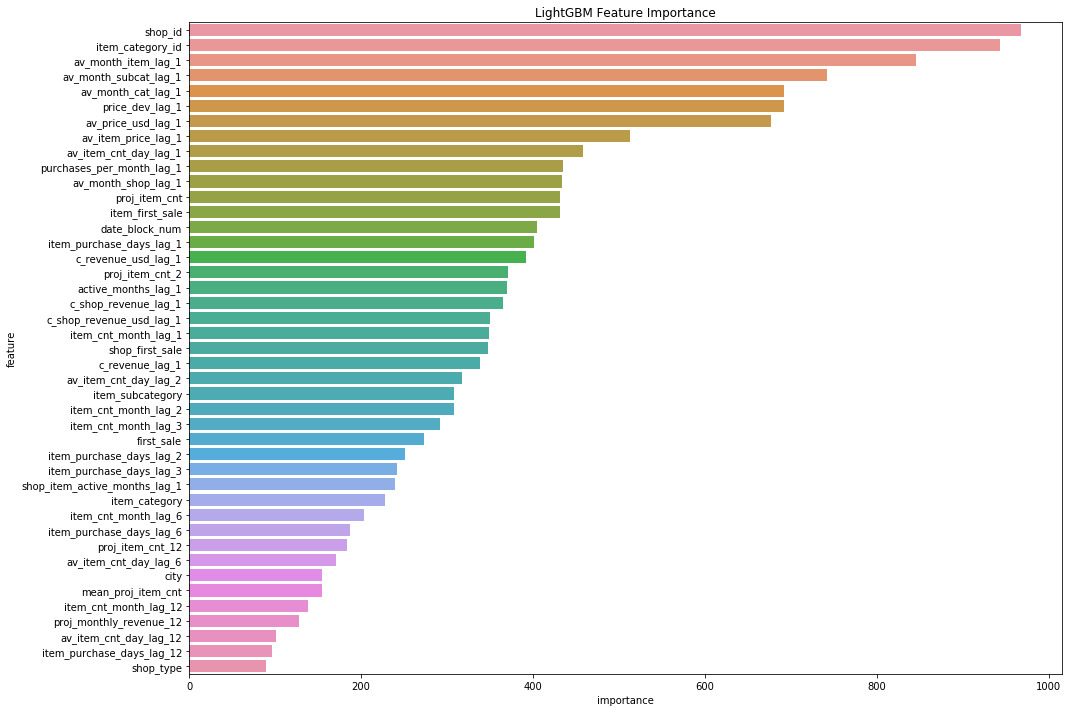

In [230]:
df_fimp = pd.DataFrame()
df_fimp["feature"] = X_train.columns.values
df_fimp["importance"] = impor1


plt.figure(figsize=(15, 10))
sns.barplot(x="importance", y="feature", data=df_fimp.sort_values(by="importance", ascending=False))
plt.title("LightGBM Feature Importance")
plt.tight_layout()

### Submission

In [231]:
test_df = pd.read_csv('../input/competitive-data-science-predict-future-sales/test.csv')

submission = pd.DataFrame({
    "ID": test_df.index, 
    "item_cnt_month": y_final_test
})
submission.to_csv('submission.csv', index=False)

LB score = 0.903

### Interpreting the results:

Feature importances from LOFO:

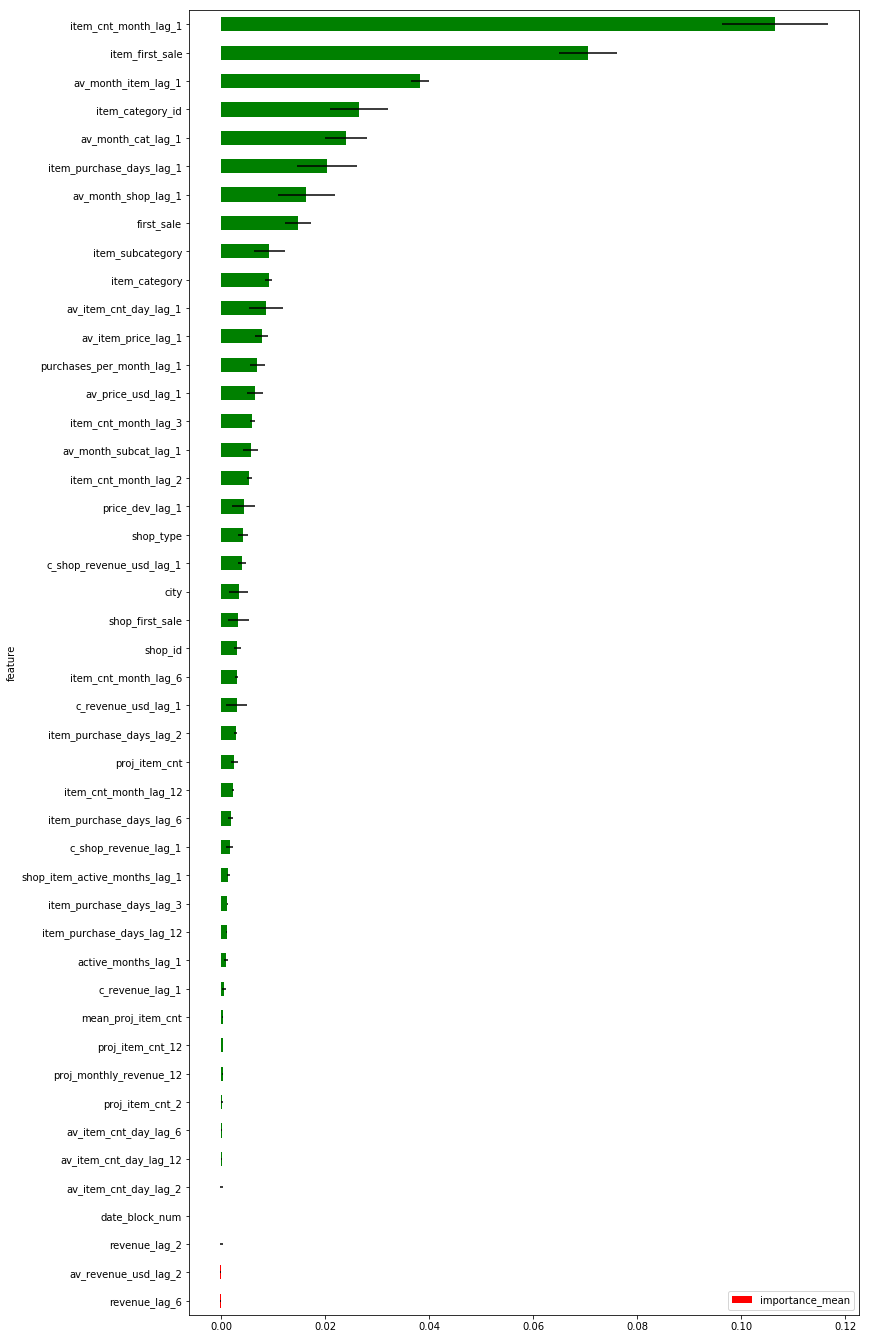

In [232]:
importance_df = pd.read_pickle('../input/1c-params/feature_importances.pkl')
plot_importance(importance_df, figsize=(12,24))

Top features description:

1) __'item_cnt_month_lag_1'__ is the target variable value in the previous month;  
2) __'item_first_sale'__ is the number of months since the introduction of a particular item on the market;  
3) __'av_month_item_lag_1'__ is the value of the target varible in the previous month averaged over all the shops;  
4) __'item_category_id'__  
5) __'av_month_cat_lag_1'__ is the value of the target varible in the previous month averaged over the category_id of each item;  
6) __'item_purchase_days_lag_1'__ number of days (in a month) when a particular item is purchased in a particular shop. Basically, it is the target variable that does not take into account the exact number of items purchased per day (i.e. it's always considered 1)
7) __'av_month_shop_lag_1'__ is the value of the target varible in the previous month averaged over the shop_id of each item;  
8) __'first_sale'__ is the number of months since the appearance of a particular item in a particular shop;  

Overall, apart from the categorical features, the final prediction mostly relies in the market condition in the previous month. Two features that are different are 'item_first_sale' and 'first_sale':

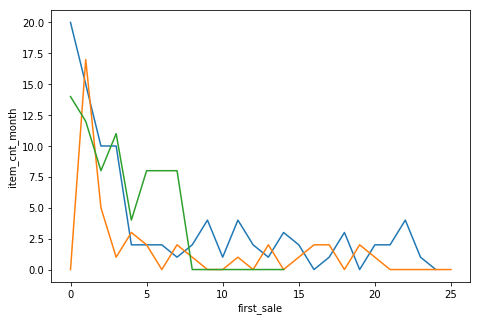

In [233]:
group = alles.groupby(['shop_id', 'item_id'])

plt.figure(figsize=(7.5, 5))
plt.plot(group.get_group((59, 2269))['first_sale'], group.get_group((59, 2269))['item_cnt_month'])
plt.plot(group.get_group((59, 10298))['first_sale'], group.get_group((59, 10298))['item_cnt_month'])
plt.plot(group.get_group((59, 4164))['first_sale'], group.get_group((59, 4164))['item_cnt_month'])
plt.ylabel('item_cnt_month')
plt.xlabel('first_sale')
plt.show()

It seems that typically sales are high right after the item introduction and decay afterwards. So, by knowing how long ago an item first appeared on the market, one might tell something about the demand.

### A simpler model

As it can be seen, the score is heavily dominated by the __'item_cnt_month_lag_1'__ feature, i.e. the value of the target value in the previous month. So, it seems logical to build a minimalistic model based on this feature and other categorical ones, such as shop_id, item_category, etc.

In [234]:
r_features = ['item_cnt_month_lag_1', 'item_category_id', 'item_subcategory',
                   'item_category', 'shop_type', 'city', 'shop_id', 'date_block_num']

r_cols = list(r_features)+['item_cnt_month']

data = alles.loc[rows, r_cols]
data = data.fillna(0)

In [235]:
X_train = data[train_rows].drop(['item_cnt_month'], axis=1)
y_train = data[train_rows]['item_cnt_month']
X_test = data[test_rows].drop(['item_cnt_month'], axis=1)
y_test = data[test_rows]['item_cnt_month']

X_final_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [236]:
categorical_features = (data.dtypes[data.dtypes.apply(str).str.startswith('int')].index).tolist()

In [237]:
categorical_features

['item_category_id',
 'item_subcategory',
 'item_category',
 'shop_type',
 'city',
 'shop_id',
 'date_block_num']

In [238]:
categorical_features = ['item_category_id',
 'item_subcategory',
 'item_category',
 'shop_type',
 'city',
 'shop_id']

In [239]:
kf = KFold(n_splits = 5, random_state=42)
resu1 = 0
impor1 = 0
resu3_mae=0
y_pred = 0
y_final_test = 0
stack_train = np.zeros([X_train.shape[0], ])
models = []
for train_index, test_index in tqdm(list(kf.split(X_train, y_train))):
    X_train2 = X_train.iloc[train_index, :]
    y_train2 = y_train.iloc[train_index]
    X_test2 = X_train.iloc[test_index, :]
    y_test2 = y_train.iloc[test_index]
    
    d_training = lgb.Dataset(X_train2, label=y_train2,
                             categorical_feature=categorical_features,
                             free_raw_data=False)
    d_test = lgb.Dataset(X_test2, label=y_test2,
                         categorical_feature=categorical_features,
                         free_raw_data=False)
    
    clf = lgb.train(params, train_set=d_training, num_boost_round=1000,
                      valid_sets=[d_training, d_test], verbose_eval=25,
                      early_stopping_rounds=50)

    models.append(clf)
    temp_predict = clf.predict(X_test2, num_iteration=clf.best_iteration)
    stack_train[test_index] = temp_predict

    y_pred += clf.predict(X_test, num_iteration=clf.best_iteration)/5
    y_final_test += clf.predict(X_final_test, num_iteration=clf.best_iteration)/5
    mse = mean_squared_error(y_test2, temp_predict)
    mae = mean_absolute_error(y_test2, temp_predict)

    resu1 += mse/5
    resu3_mae += mae/5 
    impor1 += clf.feature_importance()/5
    del X_train2, y_train2, X_test2, y_test2; gc.collect()

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.92504	valid_1's rmse: 0.938114
[50]	training's rmse: 0.897088	valid_1's rmse: 0.909645
[75]	training's rmse: 0.891823	valid_1's rmse: 0.906407
[100]	training's rmse: 0.889529	valid_1's rmse: 0.905841
[125]	training's rmse: 0.888055	valid_1's rmse: 0.905879
[150]	training's rmse: 0.887005	valid_1's rmse: 0.906161
Early stopping, best iteration is:
[115]	training's rmse: 0.888618	valid_1's rmse: 0.905667


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.939347	valid_1's rmse: 0.886353
[50]	training's rmse: 0.910167	valid_1's rmse: 0.856108
[75]	training's rmse: 0.904384	valid_1's rmse: 0.851028
[100]	training's rmse: 0.901664	valid_1's rmse: 0.849574
[125]	training's rmse: 0.900155	valid_1's rmse: 0.848923
[150]	training's rmse: 0.898959	valid_1's rmse: 0.848698
[175]	training's rmse: 0.897829	valid_1's rmse: 0.848561
[200]	training's rmse: 0.897025	valid_1's rmse: 0.848611
[225]	training's rmse: 0.896207	valid_1's rmse: 0.848791
Early stopping, best iteration is:
[192]	training's rmse: 0.897253	valid_1's rmse: 0.848504


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.891489	valid_1's rmse: 1.07565
[50]	training's rmse: 0.861856	valid_1's rmse: 1.04961
[75]	training's rmse: 0.856114	valid_1's rmse: 1.04598
[100]	training's rmse: 0.853943	valid_1's rmse: 1.04497
[125]	training's rmse: 0.852767	valid_1's rmse: 1.0446
[150]	training's rmse: 0.851809	valid_1's rmse: 1.04447
[175]	training's rmse: 0.850869	valid_1's rmse: 1.04452
[200]	training's rmse: 0.850192	valid_1's rmse: 1.04457
Early stopping, best iteration is:
[169]	training's rmse: 0.85111	valid_1's rmse: 1.04444


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.929809	valid_1's rmse: 0.921191
[50]	training's rmse: 0.900769	valid_1's rmse: 0.911773
[75]	training's rmse: 0.894725	valid_1's rmse: 0.917606
Early stopping, best iteration is:
[42]	training's rmse: 0.904802	valid_1's rmse: 0.910657


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.944674	valid_1's rmse: 0.856124
[50]	training's rmse: 0.914023	valid_1's rmse: 0.840224
[75]	training's rmse: 0.908203	valid_1's rmse: 0.839321
[100]	training's rmse: 0.905795	valid_1's rmse: 0.839813
Early stopping, best iteration is:
[74]	training's rmse: 0.908241	valid_1's rmse: 0.839184



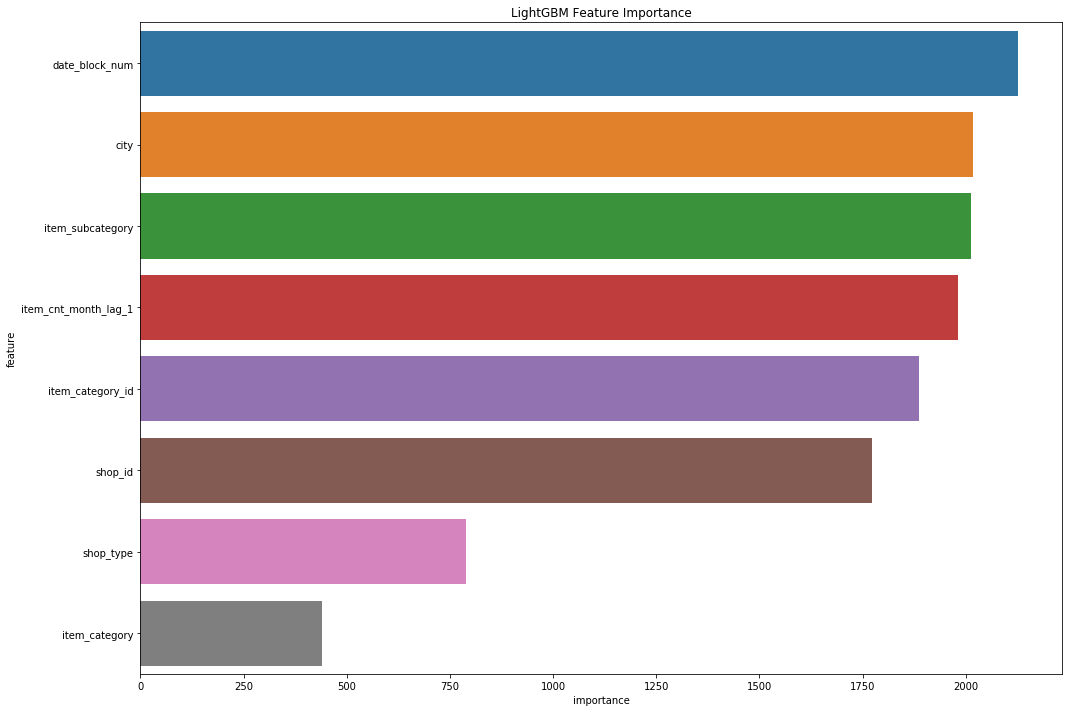

In [240]:
df_fimp = pd.DataFrame()
df_fimp["feature"] = X_train.columns.values
df_fimp["importance"] = impor1


plt.figure(figsize=(15, 10))
sns.barplot(x="importance", y="feature", data=df_fimp.sort_values(by="importance", ascending=False))
plt.title("LightGBM Feature Importance")
plt.tight_layout()

In [241]:
submission = pd.DataFrame({
    "ID": test_df.index, 
    "item_cnt_month": y_final_test
})
submission.to_csv('submission_no_features.csv', index=False)

LB Score = 1.0

So, one can get slightly worse results (~10% lower rmse) by using only the value of the target variable in the previous month and some other readily available features, thus avoiding the tedious process of feature engineering.